# Atividade 03

Aluno: Luiz Guilherme Seleme Fofano<br>
Disciplina: HIML<br>

## 1 - Importação

In [1]:
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt

In [2]:
fname = join(getcwd(),'data','data3SS2009.mat')
mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

In [3]:
Nc

850

(8192, 850)


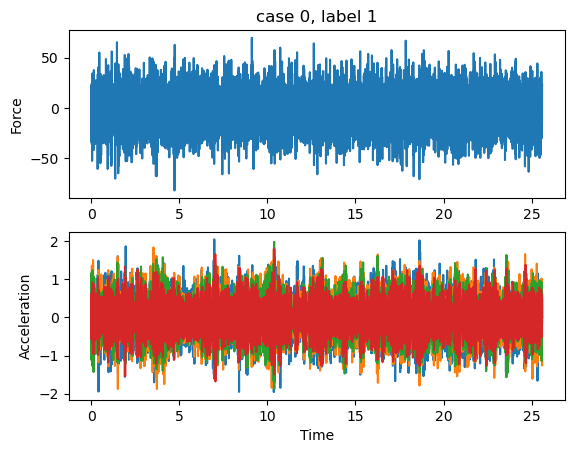

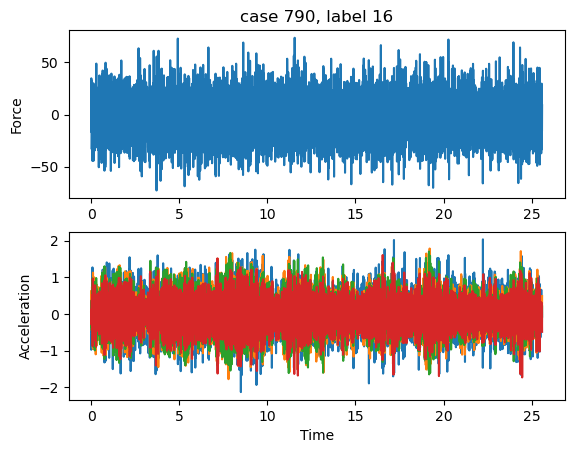

In [4]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
print(Ch1.shape)
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

## 2 - AR

In [5]:
from statsmodels.tsa.ar_model import AutoReg

In [6]:
channels = [Ch2, Ch3, Ch4, Ch5]
AR = []
order = 29 # para ficar com 30 colunas por canal (n+1)

for channel in channels:
    exp = []
    for case in range(Nc):
        reg = AutoReg(channel[:,case],lags=order).fit()
        exp.append(reg.params)
    exp = np.vstack(exp)
    AR.append(exp)

X1 = np.hstack(AR)       

In [7]:
X1.shape

(850, 120)

## 3 - Preparando os Dados

Com base na atividade 2, percebeu-se que o melhor modelo em termos de predição foi o SoftMax ajustado ao conjunto X2_sc (X2 após normalização de X1), que para este caso também será normalizado.

Dessa forma, vamos dividir o conjunto X1 normalizado entre treinamento (60%) e teste (40%), fitar o PCA apenas no conjunto de treinamento, antes de transformar o conjunto inteiro, re-normalizar os conjuntos de teste e treino pós-PCA e então testar alguns parâmetros do KNN e SVM comparados ao resultado do SoftMax com LogisticRegression.

[0.37585014 0.22279748 0.10121232 0.08300921 0.05197382 0.03813015
 0.03673931 0.02504004 0.01399312 0.01232693]


São necessários 10 componentes para atingir uma variância explicada de 0.9610725174870596 (>95%)


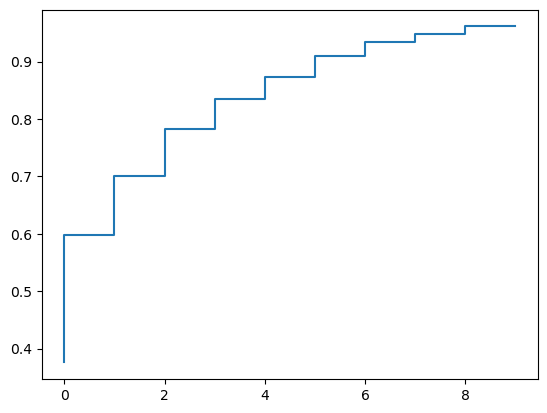

In [8]:
# Normalização
rand = 1009

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
X1_sc = scaler.fit(X1).transform(X1)


# Divisão em grupo de treinamento e teste
from sklearn.model_selection import train_test_split

X1_tr, X1_te, y_tr, y_te = train_test_split(X1_sc, y,random_state=rand,test_size=0.4)


# Aplicação do PCA e re-normalização
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)
pca.fit(X1_tr)

exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)
print(exp_var)
plt.step(range(0,len(cum_var)),cum_var,label='Cumulative variance')
print(f'\n\nSão necessários {len(exp_var)} componentes para atingir uma variância explicada de {cum_var[-1]} (>95%)')

X1_tr_pca = pca.transform(X1_tr)
X1_te_pca = pca.transform(X1_te)

X1_tr_pca_norm = scaler.fit(X1_tr_pca).transform(X1_tr_pca)
X1_te_pca_norm = scaler.fit(X1_tr_pca).transform(X1_te_pca)


## 4 - Softmax

Será utilizado apenas o conjunto X1_tr_pca_norm e X1_te_pca_norm.

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
logreg = LogisticRegression(multi_class='multinomial',random_state=rand,max_iter=10000).fit(X1_tr_pca_norm, y_tr)

score_train = logreg.score(X1_tr_pca_norm, y_tr)
score_test = logreg.score(X1_te_pca_norm, y_te)

print(f'Score de treino: {score_train}')
print(f'Score de teste: {score_test}')

Score de treino: 0.9901960784313726
Score de teste: 0.9823529411764705


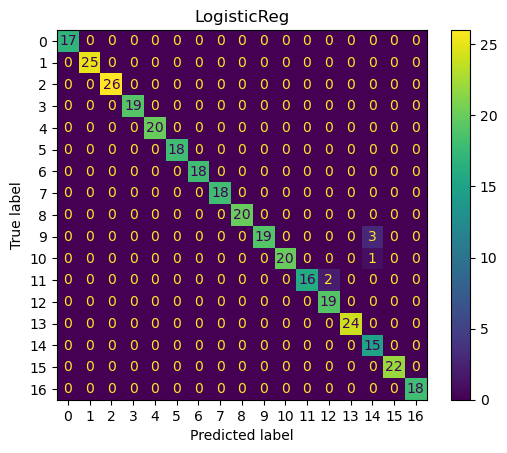

In [11]:
#plotando matriz de confusão

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_te, logreg.predict(X1_te_pca_norm))
cmgraph = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
ax.set_title('LogisticReg')
cmgraph.plot(ax=ax)

## 5 - SVM

Serão avaliados os seguintes parâmetros<br>
3 tipos de kernel : linear, RBF e poly<br>
3 valores para C: 0.1, 1, 10<br>
3 valores para degree (para o caso poly): 3, 4, 5







In [12]:
from sklearn.svm import SVC

In [13]:
C = [0.1, 1, 10]
deg = [3, 4, 5]
kernel = ['linear', 'poly', 'rbf']

score_train = []
score_test = []
legenda = []

i = -1
for ker in kernel:
    for val in C:
        if ker == 'poly':
            for num in deg:
                i = i + 1
                svm = SVC(kernel = ker,C=val,degree = num,random_state=rand).fit(X1_tr_pca_norm,y_tr)
                score_train.append(svm.score(X1_tr_pca_norm,y_tr))
                score_test.append(svm.score(X1_te_pca_norm,y_te))
                leg = ker + str(num) + ' ' + str(val)
                legenda.append(leg)
                print(f'\n{legenda[i]}:\nTrain score = {score_train[i]}\nTest score = {score_test[i]}')

        else:
            i = i + 1
            svm = SVC(kernel = ker,C=val,random_state=rand).fit(X1_tr_pca_norm,y_tr)
            score_train.append(svm.score(X1_tr_pca_norm,y_tr))
            score_test.append(svm.score(X1_te_pca_norm,y_te))
            legenda.append(ker + ' ' + str(val))
            print(f'\n{legenda[i]}:\nTrain score = {score_train[i]}\nTest score = {score_test[i]}')
            


linear 0.1:
Train score = 0.9411764705882353
Test score = 0.9205882352941176

linear 1:
Train score = 0.996078431372549
Test score = 0.9941176470588236

linear 10:
Train score = 0.9980392156862745
Test score = 0.9882352941176471

poly3 0.1:
Train score = 0.884313725490196
Test score = 0.861764705882353

poly4 0.1:
Train score = 0.8254901960784313
Test score = 0.7941176470588235

poly5 0.1:
Train score = 0.8
Test score = 0.75

poly3 1:
Train score = 0.9901960784313726
Test score = 0.9941176470588236

poly4 1:
Train score = 0.9745098039215686
Test score = 0.9852941176470589

poly5 1:
Train score = 0.9627450980392157
Test score = 0.95

poly3 10:
Train score = 0.9980392156862745
Test score = 0.9911764705882353

poly4 10:
Train score = 0.9980392156862745
Test score = 0.9823529411764705

poly5 10:
Train score = 0.9941176470588236
Test score = 0.9852941176470589

rbf 0.1:
Train score = 0.9372549019607843
Test score = 0.9235294117647059

rbf 1:
Train score = 0.996078431372549
Test score = 0.9

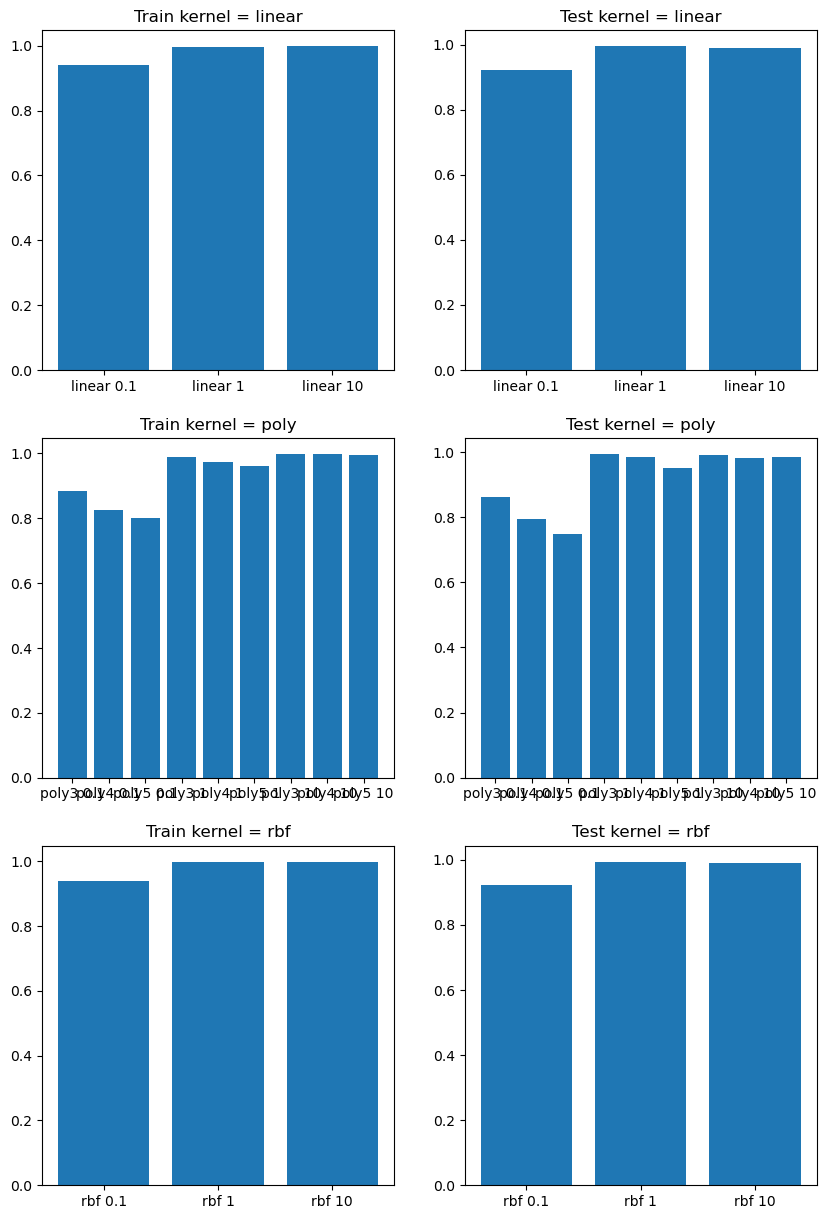

In [14]:
#plotando os scores
plt.figure(figsize=[10,15])
ax1 = plt.subplot(321)
ax1.bar(legenda[:3],score_train[:3])
ax1.title.set_text('Train kernel = linear')
ax2 = plt.subplot(322)
ax2.bar(legenda[:3],score_test[:3])
ax2.title.set_text('Test kernel = linear')

ax3 = plt.subplot(323)
ax3.bar(legenda[3:12],score_train[3:12])
ax3.title.set_text('Train kernel = poly')
ax4 = plt.subplot(324)
ax4.bar(legenda[3:12],score_test[3:12])
ax4.title.set_text('Test kernel = poly')

ax5 = plt.subplot(325)
ax5.bar(legenda[12:],score_train[12:])
ax5.title.set_text('Train kernel = rbf')
ax6 = plt.subplot(326)
ax6.bar(legenda[12:],score_test[12:])
ax6.title.set_text('Test kernel = rbf')

In [15]:
print(f'\nO melhor preditor com kernel linear foi o arranjo {legenda[score_test.index(max(score_test[:3]))]}:\nScore de teste =  {score_test[score_test.index(max(score_test[:3]))]}\n')

print(f'\nO melhor preditor com kernel poly foi o arranjo {legenda[score_test.index(max(score_test[3:12]),3,12)]}:\nScore de teste =  {score_test[score_test.index(max(score_test[3:12]),3,12)]}\n')

print(f'\nO melhor preditor com kernel rbf foi o arranjo {legenda[score_test.index(max(score_test[12:]),12)]}:\nScore de teste =  {score_test[score_test.index(max(score_test[12:]),12)]}\n')


O melhor preditor com kernel linear foi o arranjo linear 1:
Score de teste =  0.9941176470588236


O melhor preditor com kernel poly foi o arranjo poly3 1:
Score de teste =  0.9941176470588236


O melhor preditor com kernel rbf foi o arranjo rbf 1:
Score de teste =  0.9941176470588236



Pode-se obter as seguintes conclusões com relação ao SVC:<br>
* De forma geral, quanto maior o fator de regularizção, maior tende a ser o score do treino;
* Apesar disso, os melhores scores de teste foram obtidos para C = 1 (valor intermediário), porém com valores muito próximos do caso em C = 10;
* Quanto maior o grau do kernel poly, piores o score do treino e teste, confirmado pelo bom desempenho do kernel linear.

Por conta disso, serão avaliadas as matrizes de confusão dos SVC <br>
* linear C = 1;
* poly3 C = 1;
* rbf C = 1.


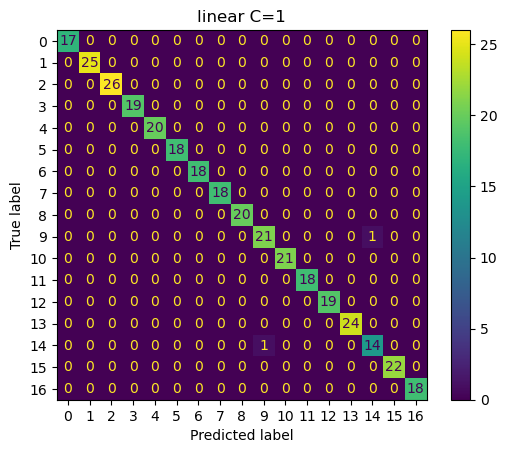

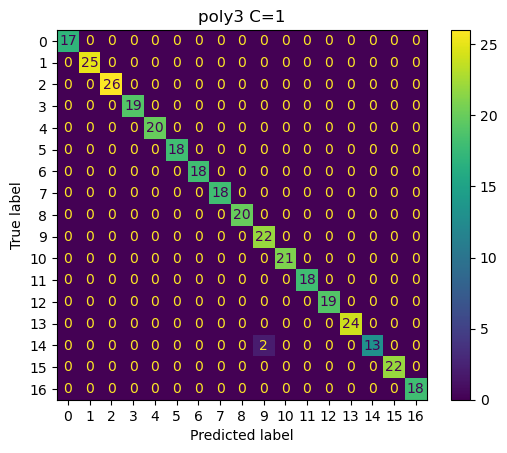

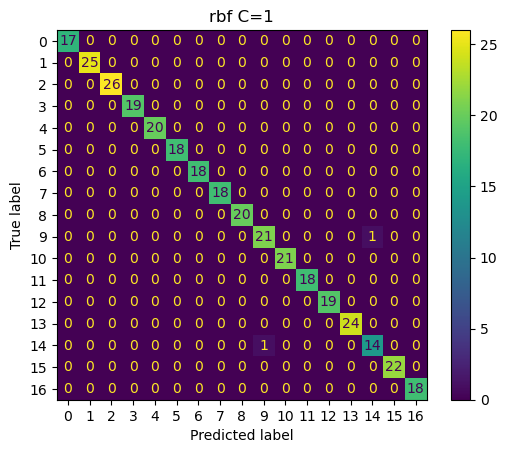

In [16]:
svm = SVC(kernel = 'linear',C=1,random_state=rand).fit(X1_tr_pca_norm,y_tr)
cm = confusion_matrix(y_te, svm.predict(X1_te_pca_norm))
cmgraph = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
ax.set_title('linear C=1')
cmgraph.plot(ax=ax)


svm = SVC(kernel = 'poly',C=1,degree=3,random_state=rand).fit(X1_tr_pca_norm,y_tr)
cm = confusion_matrix(y_te, svm.predict(X1_te_pca_norm))
cmgraph = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
ax.set_title('poly3 C=1')
cmgraph.plot(ax=ax)

svm = SVC(kernel = 'rbf',C=1,random_state=rand).fit(X1_tr_pca_norm,y_tr)
cm = confusion_matrix(y_te, svm.predict(X1_te_pca_norm))
cmgraph = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
ax.set_title('rbf C=1')
cmgraph.plot(ax=ax)


## 6 - KNN

Serão avaliados os seguintes parâmetros<br>
2 tipos de weights : uniform e distance<br>
5 valores de vizinhos: 1, 5, 10, 15, 20<br>

In [17]:
from sklearn.neighbors import KNeighborsClassifier as KNN

weight = ['uniform','distance']
neig = [1,5,10,15,20]

score_train = []
score_test = []
legenda = []

i = -1
for ker in weight:
    for val in neig:
        i = i + 1
        knn = KNN(weights = ker,n_neighbors=val).fit(X1_tr_pca_norm,y_tr)
        score_train.append(knn.score(X1_tr_pca_norm,y_tr))
        score_test.append(knn.score(X1_te_pca_norm,y_te))
        legenda.append(ker + ' ' + str(val))
        print(f'\n{legenda[i]}:\nTrain score = {score_train[i]}\nTest score = {score_test[i]}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim


uniform 1:
Train score = 1.0
Test score = 0.9852941176470589

uniform 5:
Train score = 0.9921568627450981
Test score = 0.9852941176470589

uniform 10:
Train score = 0.9882352941176471
Test score = 0.9941176470588236

uniform 15:
Train score = 0.984313725490196
Test score = 0.9911764705882353

uniform 20:
Train score = 0.9823529411764705
Test score = 0.9852941176470589

distance 1:
Train score = 1.0
Test score = 0.9852941176470589

distance 5:
Train score = 1.0
Test score = 0.9852941176470589

distance 10:
Train score = 1.0
Test score = 0.9941176470588236

distance 15:
Train score = 1.0
Test score = 0.9970588235294118

distance 20:
Train score = 1.0
Test score = 0.9882352941176471


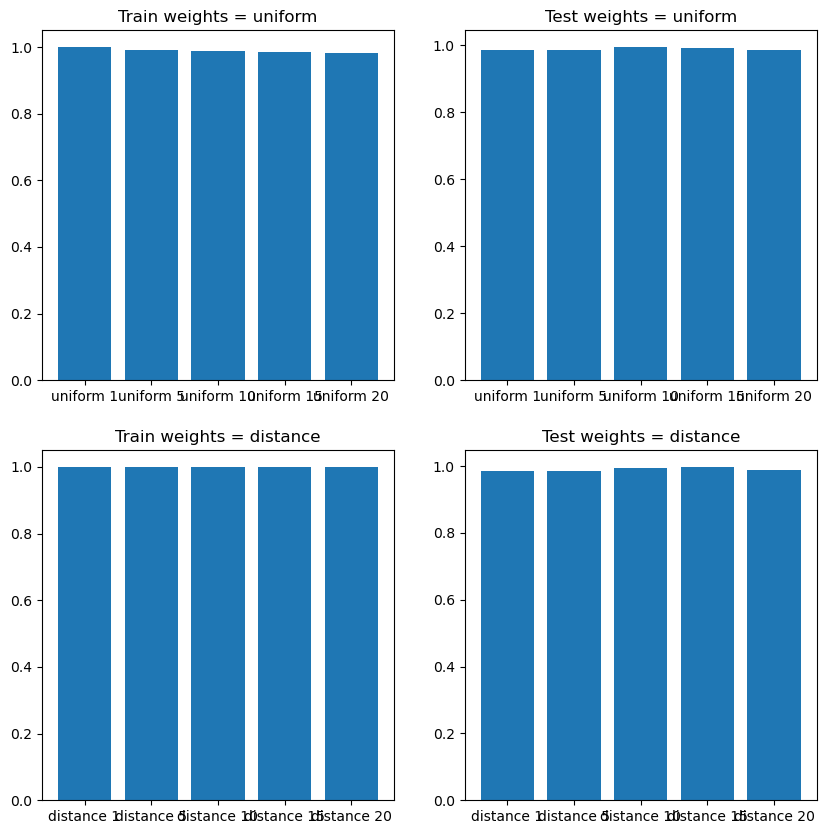

In [18]:
#plotando os scores
plt.figure(figsize=[10,10])
ax1 = plt.subplot(221)
ax1.bar(legenda[:5],score_train[:5])
ax1.title.set_text('Train weights = uniform')
ax2 = plt.subplot(222)
ax2.bar(legenda[:5],score_test[:5])
ax2.title.set_text('Test weights = uniform')

ax3 = plt.subplot(223)
ax3.bar(legenda[5:],score_train[5:])
ax3.title.set_text('Train weights = distance')
ax4 = plt.subplot(224)
ax4.bar(legenda[5:],score_test[5:])
ax4.title.set_text('Test weights = distance')

In [19]:
print(f'\nO melhor preditor com weights uniform foi o arranjo {legenda[score_test.index(max(score_test[:4]))]}:\nScore de teste =  {score_test[score_test.index(max(score_test[:4]))]}\n')

print(f'\nO melhor preditor com weights distance foi o arranjo {legenda[score_test.index(max(score_test[4:]),4)]}:\nScore de teste =  {score_test[score_test.index(max(score_test[4:]),4)]}\n')



O melhor preditor com weights uniform foi o arranjo uniform 10:
Score de teste =  0.9941176470588236


O melhor preditor com weights distance foi o arranjo distance 15:
Score de teste =  0.9970588235294118



Pode-se obter as seguintes conclusões com relação ao KNN:<br>
* o peso 'distance' parece tender a melhores scores tanto em teste como em treino do que o peso 'uniform'
* Aumentar o número de vizinhos não necessariamente aumenta o score do ajuste, sendo o ideal dentre os testados o valor de 10 para o peso uniform e 15 para o peso distance

Por conta disso, serão avaliadas as matrizes de confusão dos SVC <br>
* uniform 10
* distance 15

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


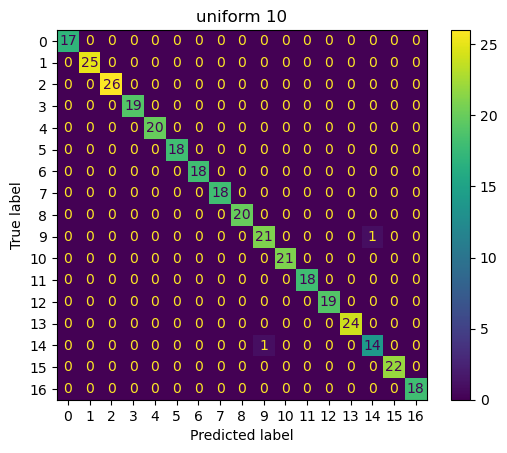

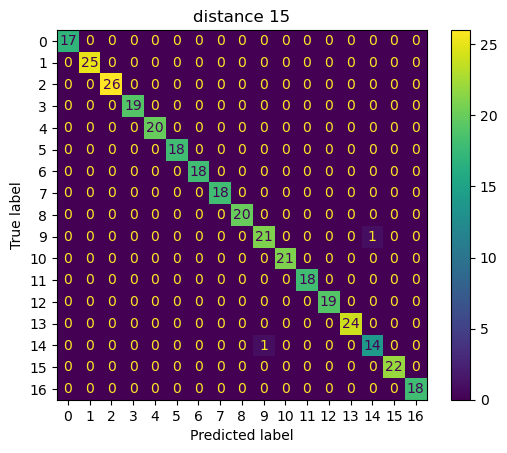

In [20]:
knn = KNN(weights = 'uniform',n_neighbors=10).fit(X1_tr_pca_norm,y_tr)
cm = confusion_matrix(y_te, knn.predict(X1_te_pca_norm))
cmgraph = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
ax.set_title('uniform 10')
cmgraph.plot(ax=ax)


knn = KNN(weights = 'distance',n_neighbors=15).fit(X1_tr_pca_norm,y_tr)
cm = confusion_matrix(y_te, svm.predict(X1_te_pca_norm))
cmgraph = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots()
ax.set_title('distance 15')
cmgraph.plot(ax=ax)

## 7 - Conclusão

Todos os preditores obtiveram score de teste maior que 0.98, sendo que o melhor preditor foi o KNN com peso por distância e 15 vizinhos, com score de teste de 0.997.
